In [1]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import pickle

from ..utils.get_models_and_set import get_model, get_test_data_latex, get_test_data_word, get_test_data_publaynet, get_train_data_latex, get_train_data_word, \
                            get_train_data_publaynet, et_test_data_latex_specify_table, get_test_data_word_specify_table, get_test_data_publaynet_specify_table, \
                            get_test_data_latex_specify_table, get_test_data_word_specify_table, get_test_data_publaynet_specify_table, \
                            get_train_data_latex_specify_table, get_train_data_word_specify_table, get_train_data_publaynet_specify_table, \
                            get_test_data_word_two_andmore, get_test_data_latex_two_andmore, get_test_data_publaynet_two_andmore, get_model, get_1k_test_set
from ..utils.metric_tablebank_my_implementation import metric_table_bank_union
from ..utils.get_iou import get_max_iou, get_iou, get_overlap

In [2]:
def draw_pred_and_truth(img, truths, preds):
    for pred in preds:
        x_min = int(pred[0])
        y_min = int(pred[1])
        x_max = int(pred[2])
        y_max = int(pred[3])
        #cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (255,0,0), 2)

    for truth in truths:
        x_min = int(truth[0])
        y_min = int(truth[1])
        x_max = int(truth[2])
        y_max = int(truth[3])
        cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (0,0,255), 2)

def draw_truth(img, truths):
    for truth in truths:
        x_min = int(truth[0])
        y_min = int(truth[1])
        x_max = int(truth[2])
        y_max = int(truth[3])
        cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (0,0,255), 2)

def draw_cv2(img, predictions):
    for pred in predictions:
        x_min, y_min, x_max, y_max = pred
        cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (138,43,226), 1)


def combine_two_models(img, preds_detectron, preds_cv2, iou_max_threshold, does_print = True):
    new_predictions = []
    i = 0

    for pred_detectron in preds_detectron:
        # Try to match a cv2_preds to a detectron pred
        result = get_max_iou(np.array(preds_cv2), pred_detectron)

        if result is not None:
            iou_max = result[1]
            index = result[2]
            associated_cv2_pred = preds_cv2[index]
            x_min_cv2, y_min_cv2, x_max_cv2, y_max_cv2 = associated_cv2_pred
            x_min_detectron, y_min_detectron, x_max_detectron, y_max_detectron = pred_detectron
            area_cv2 = (x_max_cv2 - x_min_cv2) * (y_max_cv2 - y_min_cv2)
            area_detectron = (x_max_detectron - x_min_detectron) * (y_max_detectron - y_min_detectron)
            if iou_max>=iou_max_threshold:
                if area_detectron>area_cv2:
                    new_predictions.append(associated_cv2_pred) 
                else:
                    new_predictions.append(pred_detectron) 
            else:
                new_predictions.append(pred_detectron) 
        # if we get no match
        else:
            new_predictions.append(pred_detectron) 

        # Draw
        if does_print:
            x_min, y_min, x_max, y_max = new_predictions[i]
            cv2.rectangle(img, (int(x_min), int(y_max)), (int(x_max), int(y_min)), (0,255,0), 3)
            i += 1

    return np.array(new_predictions)


# Study images

./output/word-latex/ model_final.pth


/u/yockelle/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


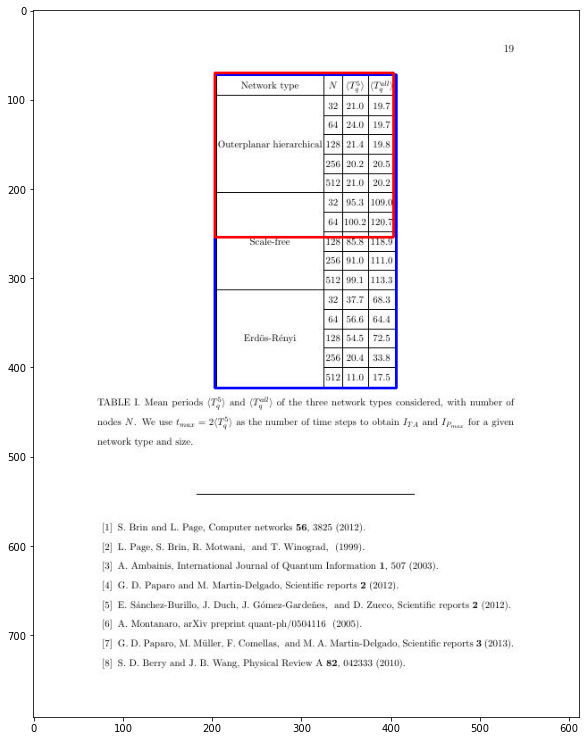

In [3]:
latex = get_1k_test_set("latex")

predictor = get_model("word-latex", "wtv", tablebank_model = False)

for dict in latex[0:10]:

    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + dict["file_name"]
    img = cv2.imread(image_name)

    outputs = predictor(img)
    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()

    for annot in dict["annotations"]:
        #if scores_detectron[j]>threshold:
        p = annot["bbox"]
        x1 = p[0]
        y1 = p[1]
        w = p[2]
        h = p[3]
        x2 = p[0] + w
        y2 = p[1] + h

        area = float(w * h)
        #if 32**2 <= area and area <= 96**2:

        for pred in predictions_detectron:
            iou = get_iou(pred, [x1,y1,x2,y2])

            if 0.5<iou and iou<0.55:
                print(iou)
                cv2.rectangle(img, (x1, y2), (x2, y1), (0,0,255), 2)
                cv2.rectangle(img, (int(pred[0]), int(pred[3])), (int(pred[2]), int(pred[1])), (255,0,0), 2)
                plt.figure(figsize = (13,13))
                plt.imshow(img)
                plt.show()
    

# Study with certain precision

In [ ]:
train_type_name = "word"
test_type_name = "word"
take_the_table_bank_model = False

is_show_image = True

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0
sum_numerator_comb = 0
sum_numerator_old_comb = 0
sum_denominator_precision_comb = 0
sum_denominator_recall_comb = 0

count_bad_precision = 0

count_bad_precision_00 = 0
count_bad_precision_0_95 = 0
count_bad_precision_95_100 = 0

predictor = get_model(train_type_name, tablebank_model = take_the_table_bank_model)

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word())
if "latex" in test_type_name:
  test_data.extend(get_test_data_latex())
if "publaynet" in test_type_name:
  test_data.extend(get_test_data_publaynet())

random.shuffle(test_data)
random_nums = random.sample(range(len(test_data)), 494)

for i in random_nums:
  image_dict = test_data[i]

  try: 
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
    im = cv2.imread(image_name)
    does_shape_work = im.shape
  except:
    image_name = image_dict["file_name"]
    im = cv2.imread(image_name)

  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()
  predictions_with_threshold = []
  for j, p in enumerate(predictions_detectron):
    if scores_detectron[j]>threshold:
      predictions_with_threshold.append(p)
  predictions_with_threshold = np.array(predictions_with_threshold)

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  # get metrics Detectron
  metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

  if metric_result != None:
    numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

    if denominator_precision>0:
      precision = numerator/denominator_precision
    else:
      precision = 0
    if denominator_recall == 0:
      print(i)
    recall = numerator/denominator_recall
    if recall==0 and precision==0:
      f1=0
    else:
      f1 = (2 * precision * recall) / (precision + recall)
    thing_to_check = f1

  if precision<=500:
    count_bad_precision += 1
    if is_show_image:
      draw_pred_and_truth(im, bbox_ground_truth, predictions_with_threshold)
      #plt.figure(figsize = (13,13))
      #plt.imshow(im)
      #plt.show()
      only_name = image_name.split("/")[-1]
      cv2.imwrite("images_problem_word/" + only_name + ".png", im)
  
  if thing_to_check == 0:
    count_bad_precision_00 += 1
  if 0 < thing_to_check <= 0.95:
    count_bad_precision_0_95 += 1
  if 0.95 < thing_to_check <= 1.00:
    count_bad_precision_95_100 += 1

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision)

print("------")
print("0 : ",count_bad_precision_00)
print(count_bad_precision_00*100/len(test_data))
print("------")
print("0 - 95: ",count_bad_precision_0_95)
print(count_bad_precision_0_95*100/len(test_data))
print("------")
print("95 - 100: ",count_bad_precision_95_100)
print(count_bad_precision_95_100*100/len(test_data))

# Study on the number of tables

In [ ]:
number_of_tables = [1,2,3,4,5,6]

for number_of_table in number_of_tables:
    word = get_train_data_word_specify_table(number_of_table)
    latex = get_train_data_latex_specify_table(number_of_table)
    publaynet = get_train_data_publaynet_specify_table(number_of_table)

    print("Number of tables ", number_of_table)
    print("word", len(word))
    print("latex", len(latex))
    print("publaynet", len(publaynet))
    print("---------")

In [22]:
train_type_name = "word-latex"
test_type_name = "publaynet"
use_table_bank_model = True

is_show_image = False

threshold = 0.9

bad_prediction = 0

number_of_tables = [1,2,3,4,5,6]

predictor = get_model(train_type_name, "X152", tablebank_model = use_table_bank_model)

for number_of_table in number_of_tables:
  precision_tab = []
  recall_tab = []

  sum_numerator = 0
  sum_numerator_old = 0
  sum_denominator_precision = 0
  sum_denominator_recall = 0

  test_data = []
  if "word" in test_type_name:
    test_data.extend(get_test_data_word_specify_table(number_of_table))
  if "latex" in test_type_name:
    #test_data.extend(get_test_data_latex_two_andmore())
    test_data.extend(get_test_data_latex_specify_table(number_of_table))
  if "publaynet" in test_type_name:
    test_data.extend(get_test_data_publaynet_specify_table(number_of_table))

  for i in range(len(test_data)):
    image_dict = test_data[i]

    try: 
      image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
      im = cv2.imread(image_name)
      does_shape_work = im.shape
    except:
      image_name = image_dict["file_name"]
      im = cv2.imread(image_name)

    outputs = predictor(im)

    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    # get metrics Detectron
    metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if metric_result != None:
      numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall

  precision = sum_numerator/sum_denominator_precision
  recall = sum_numerator/sum_denominator_recall
  f1 = (2 * precision * recall) / (precision + recall)
  print("Number of tables: ", len(test_data))
  print("Test data length: ", len(test_data))
  print("Precision ", precision*100)
  print("Recall ", recall)
  print("F1 ", f1)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


Number of tables:  3902
Test data length:  3902
Precision  96.65058036643546
Recall  0.965097037042384
F1  0.9658009066288724
Number of tables:  913
Test data length:  913
Precision  96.32641005165915
Recall  0.9114407465715139
F1  0.9366361347857747
Number of tables:  137
Test data length:  137
Precision  96.67130461093728
Recall  0.850506936810757
F1  0.9048944644558378
Number of tables:  30
Test data length:  30
Precision  97.70128221768591
Recall  0.8913237370678999
F1  0.9322032644674604
Number of tables:  4
Test data length:  4
Precision  94.86624963872895
Recall  0.6089260076463059
F1  0.7417431048482247
Number of tables:  2
Test data length:  2
Precision  95.3006193359296
Recall  0.8937965153662073
F1  0.9224522042582273


# Make graph for number of tables

In [3]:
"""
# New values with tablebank X152 word-latex model 
# Word
f1_tab_word = [85.52, 72.67, 69.94, , , ]
# Latex
f1_tab_latex = [75.50, , , , , ]
# PubLayNet
f1_tab_publaynet = [, , , , , ]

number_table = [1,2,3,4,5,6]
# Initial values with my model
"""
# Hardcoded some values
# PubLayNet
# 1: 3911 # 2: 916 # 3: 135 # 4: 32 # 5: 4 # 6: 2
precision_tab_publaynet = [97.09, 96.89, 97.08, 97.22, 96.68, 96.83]
recall_tab_publaynet = [85.54, 69.26, 54.21, 43.01, 20.56, 31.02]
f1_tab_publaynet = [90.95, 80.78, 69.57, 59.63, 33.90, 46.99]
number_table_tab_publaynet = [1,2,3,4,5,6]
# Latex
# 1: 4563 # 2: 888 # 3: 201 # 4: 43 # 5: 15 # 6: 7
precision_tab_latex = [98.34, 98.98, 96.85, 99.12, 98.99, 96.08]
recall_tab_latex = [96.26, 94.18, 90.25, 77.56, 91.44, 86.88]
#f1_tab_latex = [97.29, 96.52, 93.43, 87.02, 95.07, 91.25]
f1_tab_latex = [97.29, 96.52, 93.43, 87.02, 95.07, 91.25]
number_table_tab_latex = [1,2,3,4,5,6]
# Word
# 1: 1788 # 2: 387 # 3: 70 # 4: 27 # 5: 5 # 6: 3
precision_tab_word = [95.21, 97.94, 98.53, 98.87, 99.45, 98.74]
recall_tab_word = [88.12, 63.95, 43.07, 34.63, 25.60, 20.30]
f1_tab_word = [91.53, 77.38, 59.94, 51.29, 40.72, 33.67]
number_table = [1,2,3,4,5,6]


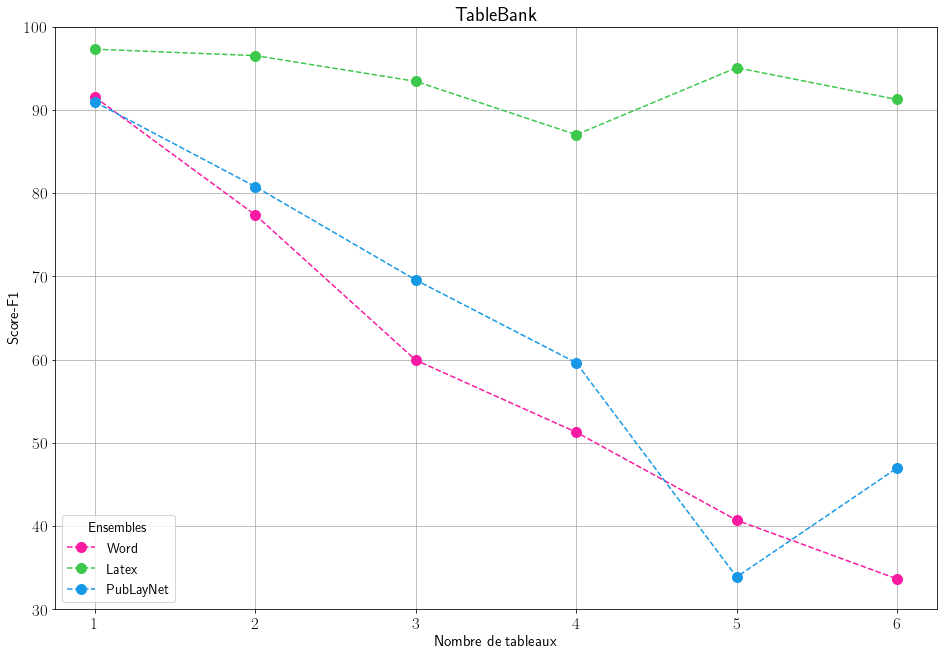

In [4]:
fig = plt.figure(figsize=(13, 9), constrained_layout=True)

plt.rcParams['text.usetex']=True
plt.rc({
    "font.family": "serif",
    "font.serif": ["Palatino"]})

colors_choices = ["#f81aa1", "#3cc84b", "#6a2020", "#ff8d00", "#ff0000", "#bc21e9", "#1798e7", "#09701d", "#2af0f0"]

plt.plot(number_table, f1_tab_word, '--o', markersize=10, color=colors_choices[0], label="Word")
plt.plot(number_table, f1_tab_latex, '--o', markersize=10, color=colors_choices[1], label="Latex")
plt.plot(number_table, f1_tab_publaynet, '--o', markersize=10, color=colors_choices[6], label="PubLayNet")

fig.patch.set_facecolor('white')
plt.grid()
plt.xlabel('Nombre de tableaux', fontsize=15)
plt.ylabel('Score-F1', fontsize=15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xlim(min(recall_with_threshold)-0.009, 1.0)
plt.ylim(30, 100)
plt.title("TableBank", fontsize=20)
plt.legend(prop={'size': 14}, title="Ensembles", title_fontsize=14)
plt.savefig("numer_of_table_effect.png")
plt.show()


In the train set

In [ ]:
total_latex = len(get_train_data_latex())
total_word = len(get_train_data_word())
total_publaynet = len(get_train_data_publaynet())

print("1 table")
print(len(get_train_data_latex_specify_table(1)), (len(get_train_data_latex_specify_table(1))/total_latex)*100)
print(len(get_train_data_word_specify_table(1)), (len(get_train_data_word_specify_table(1))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(1)), (len(get_train_data_publaynet_specify_table(1))/total_publaynet)*100)

print("2 table")
print(len(get_train_data_latex_specify_table(2)), (len(get_train_data_latex_specify_table(2))/total_latex)*100)
print(len(get_train_data_word_specify_table(2)), (len(get_train_data_word_specify_table(2))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(2)), (len(get_train_data_publaynet_specify_table(2))/total_publaynet)*100)

print("3 table")
print(len(get_train_data_latex_specify_table(3)), (len(get_train_data_latex_specify_table(3))/total_latex)*100)
print(len(get_train_data_word_specify_table(3)), (len(get_train_data_word_specify_table(3))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(3)), (len(get_train_data_publaynet_specify_table(3))/total_publaynet)*100)

print("4 table")
print(len(get_train_data_latex_specify_table(4)), (len(get_train_data_latex_specify_table(4))/total_latex)*100)
print(len(get_train_data_word_specify_table(4)), (len(get_train_data_word_specify_table(4))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(4)), (len(get_train_data_publaynet_specify_table(4))/total_publaynet)*100)

print("5 table")
print(len(get_train_data_latex_specify_table(5)), (len(get_train_data_latex_specify_table(5))/total_latex)*100)
print(len(get_train_data_word_specify_table(5)), (len(get_train_data_word_specify_table(5))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(5)), (len(get_train_data_publaynet_specify_table(5))/total_publaynet)*100)

print("6 table")
print(len(get_train_data_latex_specify_table(6)), (len(get_train_data_latex_specify_table(6))/total_latex)*100)
print(len(get_train_data_word_specify_table(6)), (len(get_train_data_word_specify_table(6))/total_word)*100)
print(len(get_train_data_publaynet_specify_table(6)), (len(get_train_data_publaynet_specify_table(6))/total_publaynet)*100)

In [ ]:
total_latex = len(get_train_data_latex())
total_word = len(get_train_data_word())
total_publaynet = len(get_train_data_publaynet())

# Archive

In [ ]:
train_type_name = "latex"
test_type_name = "word"
take_the_table_bank_model = False

is_show_image = True

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0
count_bad_precision = 0

i_want_to_count = 0

predictor = get_model(train_type_name, tablebank_model = take_the_table_bank_model)

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word())
if "latex" in test_type_name:
  test_data.extend(sample(get_test_data_latex(),1000))
if "publaynet" in test_type_name:
  test_data.extend(get_test_data_publaynet())

for i in range(len(test_data)):
  #if i%1000 == 0:
  #  print(i)
  image_dict = test_data[i]

  try: 
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
    im = cv2.imread(image_name)
    does_shape_work = im.shape
  except:
    image_name = image_dict["file_name"]
    im = cv2.imread(image_name)

  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()
  predictions_with_threshold = []
  for j, p in enumerate(predictions_detectron):
    if scores_detectron[j]>threshold:
      predictions_with_threshold.append(p)
  predictions_with_threshold = np.array(predictions_with_threshold)

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  # get metrics Detectron
  metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

  if metric_result != None:
    numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

    if denominator_precision>0:
      precision = numerator/denominator_precision
    else:
      precision = 0
    recall = numerator/denominator_recall
    if recall==0 and precision==0:
      f1=0
    else:
      f1 = (2 * precision * recall) / (precision + recall)
    thing_to_check = f1

  if f1<=0.1:
    count_bad_precision += 1
    if is_show_image:
      draw_pred_and_truth(im, bbox_ground_truth, predictions_with_threshold)
      #plt.figure(figsize = (13,13))
      #plt.imshow(im)
      #plt.show()
      i_want_to_count += 1
      only_name = image_name.split("/")[-1]
      cv2.imwrite("images_problem_word/" + only_name + ".png", im)
  
precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision)

In [ ]:
with open('problematic_word_random.pkl', 'rb') as f:
    interdit_word = pickle.load(f)
print(len(interdit_word))

In [ ]:
train_type_name = "word"
test_type_name = "word"
take_the_table_bank_model = True

is_show_image = False

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0
count_bad_precision = 0

i_want_to_count = 0

predictor = get_model(train_type_name, tablebank_model = take_the_table_bank_model)

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word())

for i in range(len(test_data)):

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  does_shape_work = im.shape
  name = image_dict["file_name"].split("/")[-1]

  if name not in interdit_word:
    i_want_to_count += 1

    outputs = predictor(im)
    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    # get metrics Detectron
    metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if metric_result != None:
      numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision)

In [ ]:
train_type_name = "latex"
test_type_name = "word"
take_the_table_bank_model = True

is_show_image = False

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0
count_bad_precision = 0

i_want_to_count = 0

predictor = get_model(train_type_name, tablebank_model = take_the_table_bank_model)

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word())

for i in range(len(test_data)):

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  does_shape_work = im.shape
  name = image_dict["file_name"].split("/")[-1]

  if name not in interdit_word:
    i_want_to_count += 1

    outputs = predictor(im)
    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    # get metrics Detectron
    metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if metric_result != None:
      numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall
  
precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision)

In [ ]:
train_type_name = "word-latex"
test_type_name = "word"
take_the_table_bank_model = True

is_show_image = False

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0
count_bad_precision = 0

i_want_to_count = 0

predictor = get_model(train_type_name, tablebank_model = take_the_table_bank_model)

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word())

for i in range(len(test_data)):

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  does_shape_work = im.shape
  name = image_dict["file_name"].split("/")[-1]

  if name not in interdit_word:
    i_want_to_count += 1

    outputs = predictor(im)
    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    # get metrics Detectron
    metric_result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if metric_result != None:
      numerator, denominator_precision, denominator_recall, old_way_area_union = metric_result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall
  
precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("\n")
print("Number of bad precision: ", count_bad_precision)